In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
from datetime import datetime
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
import tensorflow.keras.backend as K
from sklearn import decomposition

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

#dont keep api key in github!!!
api_file = os.path.join('..','..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

print(tf.__version__)

2.0.0


In [2]:
sns.set_style('ticks')

In [3]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes')
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']] 
print(len(hero_vocab))

117


# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [4]:
def _parse_function(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8-bit ints for heroes
        "label": tf.io.FixedLenFeature(1, tf.int64)
                }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    
    labels = parsed_features['label']
    
    #return radiant_heroes,dire_heroes, labels
    return {'radiant_heroes':radiant_heroes,'dire_heroes': dire_heroes}, labels

In [5]:
def _parse_function_nodict(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8-bit ints for heroes
        "label": tf.io.FixedLenFeature(1, tf.int64)
                }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    
    labels = parsed_features['label']
    
    return [radiant_heroes,dire_heroes], labels

In [6]:
def _parse_function_dual(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return [radiant_heroes,dire_heroes],\
        {'gold_diff': gold_diff, 'radiant_win':radiant_win}

In [7]:
def _parse_function_triple(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A 2D tensors representing the heroes
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_gold": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']
    total_gold = parsed_features['total_gold']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return [radiant_heroes,dire_heroes],\
            {'gold_diff': gold_diff,
                 'total_gold':total_gold,
                 'radiant_win':radiant_win}

In [8]:
def _parse_function_penta(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A 2D tensors representing the heroes
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_gold": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "tower_damage_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_tower_damage": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']
    total_gold = parsed_features['total_gold']
    towdam_diff = parsed_features['tower_damage_diff']
    total_towdam = parsed_features['total_tower_damage']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return [radiant_heroes,dire_heroes],\
            {'gold_diff': gold_diff,
                 'total_gold':total_gold,
                 'tower_damage_diff':towdam_diff,
                 'total_tower_damage': total_towdam,
                 'radiant_win':radiant_win}

#### Check the parse function worked

In [12]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('Dota_data',
                                          'mixed_skill',
                                          'dota2_training_data',
                                          'dual_gold_win_novocab_dota2_training_data.tfrecords'),
                             compression_type="GZIP")
# Map features and labels with the parse function.
ds = ds.map(_parse_function_dual)

In [13]:
ds = ds.shuffle(10000)
print(tf.data.experimental.get_single_element(ds.take(1))[1])

{'gold_diff': <tf.Tensor: id=83, shape=(1,), dtype=float32, numpy=array([0.86686844], dtype=float32)>, 'radiant_win': <tf.Tensor: id=84, shape=(1,), dtype=int64, numpy=array([1])>}


## Model Functions

In [14]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_multi(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type="",target_num=2):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    
    if target_num==2:
        ds = ds.map(_parse_function_dual)
    elif target_num==3:
        ds = ds.map(_parse_function_triple)
    elif target_num==5:
        ds = ds.map(_parse_function_penta)
    elif target_num==1:
        ds = ds.map(_parse_function_nodict)
    else:
        raise KeyError
    
    if shuffle:
        ds = ds.shuffle(10000)
    
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    #gold_ds = ds.map(_parse_function_multi_to_gold)
    #win_ds = ds.map(_parse_function_multi_to_win)
    
    # Return the dataset.
    #return gold_ds, win_ds
    return ds

In [15]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_single_example(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
   # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function_nodict)

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    
    # Return the dataset.
    return ds

In [16]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    # Return the dataset.
    return ds

## Define and train the linear model

### various iterations of linear models

In [17]:
#define the linear model with no feature columns
def train_linear_model_no_feature_columns(optimizer, 
                                          vocab_len, 
                                          embedding_dims,
                                          batch_size,
                                          epochs,
                                          training_path,
                                          validation_path,
                                          compression_type='',
                                          temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        history: A `tf.keras.history` object that has loss and other metrics
    '''

    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    x = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single embedded vector for each team
    x = tf.keras.layers.Dense(1, activation='linear')(x)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)

    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=all_heroes,
                           outputs=win_predict,name="linear_classifier")
    
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = triple_model.layers[1].get_weights()[0]
    
    #get datasets from tfrecords and according to input_fn
    train_ds = _input_fn_single_example(training_path,
                                       batch_size=batch_size,
                                       compression_type=compression_type)

    validation_ds= _input_fn_single_example(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type)

    #allow logging in temp directory or directory to be included in git
    #  useful if tuning hyperparams or testing
    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    steps_per_epoch=10
    history = model.fit(train_ds, 
                        epochs = epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=steps_per_epoch,
                        verbose=1,
                        validation_data=validation_ds,
                        callbacks=[tensorboard_callback]
                       )
    
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')
    
    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item()
    training_params = dict({'model_type':'triple_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding)
    
    fig,ax = plt.subplots(1,1,figsize=(1.6*3,3))
    plt.plot(history.history['accuracy'])
    plt.xlabel('epochs (10 steps per)')
    plt.ylabel('accuracy')
    plt.show()
    
    return history

In [18]:
#define the linear model with feature columns
def linear_model(optimizer, feature_columns):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Sequential` model
    '''
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

    model = tf.keras.Sequential([
        feature_layer,
        #Adds output layer with softmax activation for prediction
        tf.keras.layers.Dense(1,activation='sigmoid')
                                ])
    
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [19]:
#define the linear model with feature columns and dual targets
def train_linear_model_dual(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    aux_pred = tf.keras.layers.Dense(1,activation='linear',
                                      name='aux_feature')(x)
    
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)

    win_inputs = tf.keras.layers.concatenate([x,aux_pred])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    dual_model = tf.keras.Model(inputs=all_heroes, outputs=[aux_pred,win_pred])
    dual_model.compile(optimizer=optimizer,
                      loss = ['mse', 'binary_crossentropy'],
                      loss_weights = [aux_weight, 1],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = triple_model.layers[1].get_weights()[0]

    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=2)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=2)

    #allow logging in temp directory or directory to be included in git
    #  useful if tuning hyperparams or testing
    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))

    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
    #fit model and keep history object for returning
    steps_per_epoch=50
    history = dual_model.fit(train_ds, 
                             epochs = epochs,
                             steps_per_epoch=steps_per_epoch,
                             validation_steps=steps_per_epoch,
                             verbose=2,
                             validation_data=val_ds,
                             callbacks=[tensorboard_callback]
                            )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    dual_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')
    
    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item() #numpy can't be serialized
    training_params = dict({'model_type':'triple_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding)
    
    fig, (ax1,ax2)= plt.subplots(1,2,sharey=False,figsize=(5*1.6,5))
    ax2.plot(history.history['gold_diff_loss'])
    ax1.plot(history.history['radiant_win_loss'])
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('win_loss')
    ax2.set_ylabel('gold_loss')
    plt.show()

    fig,ax = plt.subplots(1,1,figsize=(1.6*3,3))
    plt.plot(history.history['radiant_win_accuracy'])
    plt.xlabel('epochs (50 steps per)')
    plt.ylabel('accuracy')
    plt.show()

    #return gold_history,win_history
    return history

In [20]:
#define the linear model with feature columns and three targets
def train_linear_model_triple(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    gold_diff = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    total_gold = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_gold')(x)
    
    #do similar fit and processing layers starting for radiant_win,
    #  and use gold_diff and total_gold to help predict win
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    win_inputs = tf.keras.layers.concatenate([x,gold_diff,total_gold])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    
    #create and compile model with three outputs
    #  with auxiliary outputs deemphasized by aux_weight
    triple_model = tf.keras.Model(inputs=all_heroes, outputs=[gold_diff,
                                                            total_gold,
                                                            win_pred])
    triple_model.compile(optimizer=optimizer,
                      loss = ['mse','mse', 'binary_crossentropy'],
                      loss_weights = [aux_weight,aux_weight, 1/0.7],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = triple_model.layers[1].get_weights()[0]
    
    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=3)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=3)
    
    #log training data in temp folder unless the flag is false
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                          write_images=True,
                                                          embeddings_freq=1)
    #fit model
    steps_per_epoch = 50
    history = triple_model.fit(train_ds, 
                               epochs = epochs,
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=steps_per_epoch,
                               verbose=0,
                               validation_data=val_ds,
                               callbacks=[tensorboard_callback]
                               )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    triple_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')

    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item()
    training_params = dict({'model_type':'triple_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)

    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding)

    #plot results with loss side by side and win accuracy alone
    fig, [ax1,ax2,ax3]= plt.subplots(1,3,sharey=False,figsize=(5*1.6,5))
    ax3.plot(history.history['total_gold_loss'])
    ax2.plot(history.history['gold_diff_loss'])
    ax1.plot(history.history['radiant_win_loss'])
    ax3.set_xlabel('epochs (50 steps per)')
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('radiant_win loss')
    ax2.set_ylabel('gold_diff loss')
    ax3.set_ylabel('total_gold loss')
    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,1,figsize=(3*1.6,3))
    plt.plot(history.history['radiant_win_accuracy'])
    plt.xlabel('epochs (50 steps per)')
    plt.ylabel('accuracy')
    plt.show()

    #return embedding weights and history for model.fit
    return history

In [21]:
#define the linear model with feature columns and three targets
def train_linear_model_penta(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    gold_diff = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    total_gold = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_gold')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    towdam_diff= tf.keras.layers.Dense(1,activation='linear',
                                        name = 'tower_damage_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    total_towdam = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_tower_damage')(x)
    
    #do similar fit and processing layers starting for radiant_win,
    #  and use gold_diff and total_gold to help predict win
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    win_inputs = tf.keras.layers.concatenate([x,gold_diff,total_gold,
                                             towdam_diff,total_towdam])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    
    #create and compile model with three outputs
    #  with auxiliary outputs deemphasized by aux_weight
    penta_model = tf.keras.Model(inputs=all_heroes, outputs=[gold_diff,
                                                            total_gold,
                                                            towdam_diff,
                                                            total_towdam,
                                                            win_pred])
    penta_model.compile(optimizer=optimizer,
                      loss = ['mse','mse',
                              'mse','mse',
                              'binary_crossentropy'],
                      loss_weights = [aux_weight,aux_weight,
                                      aux_weight,aux_weight,
                                      1/0.7],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = penta_model.layers[1].get_weights()[0]
    
    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=5)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=5)
    
    #log training data in temp folder unless the flag is false
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                          write_images=True,
                                                          embeddings_freq=1)
    #fit model
    steps_per_epoch = 50
    history = penta_model.fit(train_ds, 
                               epochs = epochs,
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=steps_per_epoch,
                               verbose=0,
                               validation_data=val_ds,
                               callbacks=[tensorboard_callback]
                               )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    penta_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')

    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item() #numpy can't be serialized
    training_params = dict({'model_type':'penta_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)

    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)

    #plot results with loss side by side and win accuracy alone
    fig, ax= plt.subplots(2,2,sharey=True,figsize=(5*1.6,5),sharex=True)
    ax[0,0].plot(history.history['total_gold_loss'])
    ax[0,1].plot(history.history['gold_diff_loss'])
    ax[1,0].plot(history.history['total_tower_damage_loss'])
    ax[1,1].plot(history.history['tower_damage_diff_loss'])
    #ax[0,0].set_xticks([])
    #ax[0,1].set_xticks([])
    #ax[0,1].set_yticks([])
    #ax[1,1].set_yticks([])
    ax[0,0].set_ylabel('total and diff gold loss')
    #ax[1,0].set_ylabel('gold_diff loss')
    ax[1,0].set_ylabel('total and diff tower_damage loss')
    #ax[1,1].set_ylabel('tower_damage_diff loss')
    ax[1,0].set_xlabel('epochs(50 steps per)')
    ax[1,1].set_xlabel('epochs(50 steps per)')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(1.6*3,6),sharex=True)
    ax1.plot(history.history['radiant_win_loss'])
    ax2.plot(history.history['radiant_win_accuracy'])
    #ax1.set_xticks([])
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('radiant_win_loss')
    ax2.set_ylabel('accuracy')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    #return embedding weights and history for model.fit
    return history

In [26]:
#define the linear model with feature columns and three targets
def train_linear_model_penta_auxconnect(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    total_gold = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_gold')(x)

    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,total_gold])
    gold_diff = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,gold_diff,total_gold])
    total_towdam = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_tower_damage')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,gold_diff,total_gold,total_towdam])
    towdam_diff= tf.keras.layers.Dense(1,activation='linear',
                                        name = 'tower_damage_diff')(x)
    
    #do similar fit and processing layers starting for radiant_win,
    #  and use gold_diff and total_gold to help predict win
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    win_inputs = tf.keras.layers.concatenate([x,gold_diff,total_gold,
                                             towdam_diff,total_towdam])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    
    #create and compile model with three outputs
    #  with auxiliary outputs deemphasized by aux_weight
    penta_model = tf.keras.Model(inputs=all_heroes, outputs=[gold_diff,
                                                            total_gold,
                                                            towdam_diff,
                                                            total_towdam,
                                                            win_pred])
    penta_model.compile(optimizer=optimizer,
                      loss = ['mse','mse',
                              'mse','mse',
                              'binary_crossentropy'],
                      loss_weights = [aux_weight,aux_weight,
                                      aux_weight,aux_weight,
                                      1/0.7],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = penta_model.layers[1].get_weights()[0]
    
    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=5)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=5)
    
    #log training data in temp folder unless the flag is false
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                          write_images=True,
                                                          embeddings_freq=1)
    #fit model
    steps_per_epoch = 50
    history = penta_model.fit(train_ds, 
                               epochs = epochs,
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=steps_per_epoch,
                               verbose=0,
                               validation_data=val_ds,
                               callbacks=[tensorboard_callback]
                               )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    penta_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')

    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item() #numpy can't be serialized
    training_params = dict({'model_type':'penta_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)

    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)

    #plot results with loss side by side and win accuracy alone
    fig, ax= plt.subplots(2,2,sharey=True,figsize=(5*1.6,5),sharex=True)
    ax[0,0].plot(history.history['total_gold_loss'])
    ax[0,1].plot(history.history['gold_diff_loss'])
    ax[1,0].plot(history.history['total_tower_damage_loss'])
    ax[1,1].plot(history.history['tower_damage_diff_loss'])
    #ax[0,0].set_xticks([])
    #ax[0,1].set_xticks([])
    #ax[0,1].set_yticks([])
    #ax[1,1].set_yticks([])
    ax[0,0].set_ylabel('total and diff gold loss')
    #ax[1,0].set_ylabel('gold_diff loss')
    ax[1,0].set_ylabel('total and diff tower_damage loss')
    #ax[1,1].set_ylabel('tower_damage_diff loss')
    ax[1,0].set_xlabel('epochs(50 steps per)')
    ax[1,1].set_xlabel('epochs(50 steps per)')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(1.6*3,6),sharex=True)
    ax1.plot(history.history['radiant_win_loss'])
    ax2.plot(history.history['radiant_win_accuracy'])
    #ax1.set_xticks([])
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('radiant_win_loss')
    ax2.set_ylabel('accuracy')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    #return embedding weights and history for model.fit
    return history

### Train model

In [23]:
def train_model(optimizer,
                embedding_dim,
                batch_size, 
                epochs, 
                training_path, 
                validation_path, 
                compression_type=''):
    """Trains a keras model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        optimizer: A `tf.keras.optimizer` to optimize loss with
        model_type: A `string` specifying the model to use
        feature_column: An `tf.feature_column` containing input data
        epochs: A non-zero `int`, the total number of training epochs. A training epoch
          consists of a forward and backward pass using a single batch.
        batch_size: A `int` specifying the number of examples for each training step.
        feature_columns: A `set` specifying the input feature columns to use.
        training_path: A `string` specifying the path to the TFRecord training data.
        validation_path: A `string` specifying the path to the TFRecord training data.
        compression_type: A `string` specifying the type of compression used for the TFRecords
      
    Returns:
        A keras `history` object trained on the training data.
    """
    
    #make linear model
    model = linear_model(optimizer,embedding_dim,vocab_len)

    
    #get batched datasets
    training_dataset = _input_fn(training_path,
                                       batch_size=batch_size,
                                       compression_type=compression_type)
    validation_dataset = _input_fn(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type)
    
    logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
    history = model.fit(training_dataset, 
                        epochs = epochs,
                        steps_per_epoch=10,
                        validation_steps=10,
                        verbose=0,
                        validation_data=validation_dataset,
                        callbacks=[tensorboard_callback]
                       )
    
    plt.plot(history.history['accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return history

### train no feature column win model

In [ ]:
training_file_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_win_novocab_dota2_training_data.tfrecords')
validation_file_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_win_novocab_dota2_validation_data.tfrecords')

Train for 10 steps, validate for 10 steps
Epoch 1/500
10/10 [==============================] - 3s 313ms/step - loss: 0.6922 - accuracy: 0.5418 - val_loss: 0.6913 - val_accuracy: 0.5492
Epoch 2/500
10/10 [==============================] - 1s 128ms/step - loss: 0.6909 - accuracy: 0.5472 - val_loss: 0.6900 - val_accuracy: 0.5474
Epoch 3/500
10/10 [==============================] - 1s 128ms/step - loss: 0.6886 - accuracy: 0.5572 - val_loss: 0.6881 - val_accuracy: 0.5524
Epoch 4/500
10/10 [==============================] - 1s 124ms/step - loss: 0.6883 - accuracy: 0.5434 - val_loss: 0.6863 - val_accuracy: 0.5562
Epoch 5/500
10/10 [==============================] - 1s 129ms/step - loss: 0.6885 - accuracy: 0.5356 - val_loss: 0.6858 - val_accuracy: 0.5532
Epoch 6/500
10/10 [==============================] - 1s 137ms/step - loss: 0.6871 - accuracy: 0.5388 - val_loss: 0.6846 - val_accuracy: 0.5506
Epoch 7/500
10/10 [==============================] - 2s 155ms/step - loss: 0.6852 - accuracy: 0.5472

Epoch 58/500
10/10 [==============================] - 1s 122ms/step - loss: 0.6685 - accuracy: 0.5926 - val_loss: 0.6679 - val_accuracy: 0.5920
Epoch 59/500
10/10 [==============================] - 1s 123ms/step - loss: 0.6699 - accuracy: 0.5846 - val_loss: 0.6647 - val_accuracy: 0.5966
Epoch 60/500
10/10 [==============================] - 1s 122ms/step - loss: 0.6677 - accuracy: 0.5894 - val_loss: 0.6658 - val_accuracy: 0.5960
Epoch 61/500
10/10 [==============================] - 1s 122ms/step - loss: 0.6653 - accuracy: 0.5986 - val_loss: 0.6654 - val_accuracy: 0.5966
Epoch 62/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6708 - accuracy: 0.5912 - val_loss: 0.6662 - val_accuracy: 0.5904
Epoch 63/500
10/10 [==============================] - 1s 124ms/step - loss: 0.6679 - accuracy: 0.5880 - val_loss: 0.6613 - val_accuracy: 0.6010
Epoch 64/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6635 - accuracy: 0.5980 - val_loss: 0.6667 - val_accuracy:

Epoch 115/500
10/10 [==============================] - 1s 120ms/step - loss: 0.6671 - accuracy: 0.5954 - val_loss: 0.6663 - val_accuracy: 0.5968
Epoch 116/500
10/10 [==============================] - 1s 119ms/step - loss: 0.6693 - accuracy: 0.5958 - val_loss: 0.6628 - val_accuracy: 0.5998
Epoch 117/500
10/10 [==============================] - 1s 119ms/step - loss: 0.6717 - accuracy: 0.5858 - val_loss: 0.6691 - val_accuracy: 0.5864
Epoch 118/500
10/10 [==============================] - 1s 119ms/step - loss: 0.6631 - accuracy: 0.6034 - val_loss: 0.6692 - val_accuracy: 0.5858
Epoch 119/500
10/10 [==============================] - 1s 116ms/step - loss: 0.6645 - accuracy: 0.5942 - val_loss: 0.6669 - val_accuracy: 0.5946
Epoch 120/500
10/10 [==============================] - 1s 91ms/step - loss: 0.6688 - accuracy: 0.5910 - val_loss: 0.6655 - val_accuracy: 0.5914
Epoch 121/500
10/10 [==============================] - 1s 149ms/step - loss: 0.6670 - accuracy: 0.5788 - val_loss: 0.6667 - val_acc

10/10 [==============================] - 1s 132ms/step - loss: 0.6718 - accuracy: 0.5856 - val_loss: 0.6678 - val_accuracy: 0.5892
Epoch 228/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6608 - accuracy: 0.6078 - val_loss: 0.6679 - val_accuracy: 0.5900
Epoch 229/500
10/10 [==============================] - 1s 136ms/step - loss: 0.6705 - accuracy: 0.5796 - val_loss: 0.6633 - val_accuracy: 0.5920
Epoch 230/500
10/10 [==============================] - 1s 135ms/step - loss: 0.6648 - accuracy: 0.5920 - val_loss: 0.6705 - val_accuracy: 0.5824
Epoch 231/500
10/10 [==============================] - 1s 133ms/step - loss: 0.6677 - accuracy: 0.5934 - val_loss: 0.6646 - val_accuracy: 0.5922
Epoch 232/500
10/10 [==============================] - 1s 138ms/step - loss: 0.6715 - accuracy: 0.5834 - val_loss: 0.6659 - val_accuracy: 0.5924
Epoch 233/500
10/10 [==============================] - 1s 132ms/step - loss: 0.6685 - accuracy: 0.5880 - val_loss: 0.6672 - val_accuracy: 0.5884

10/10 [==============================] - 1s 124ms/step - loss: 0.6695 - accuracy: 0.5872 - val_loss: 0.6671 - val_accuracy: 0.5854
Epoch 340/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6670 - accuracy: 0.5908 - val_loss: 0.6652 - val_accuracy: 0.5968
Epoch 341/500
10/10 [==============================] - 1s 128ms/step - loss: 0.6653 - accuracy: 0.5978 - val_loss: 0.6669 - val_accuracy: 0.5920
Epoch 342/500
10/10 [==============================] - 1s 126ms/step - loss: 0.6679 - accuracy: 0.5866 - val_loss: 0.6642 - val_accuracy: 0.5952
Epoch 343/500
10/10 [==============================] - 1s 125ms/step - loss: 0.6646 - accuracy: 0.5986 - val_loss: 0.6625 - val_accuracy: 0.6000
Epoch 344/500
10/10 [==============================] - 1s 123ms/step - loss: 0.6745 - accuracy: 0.5810 - val_loss: 0.6711 - val_accuracy: 0.5884
Epoch 345/500
10/10 [==============================] - 1s 124ms/step - loss: 0.6621 - accuracy: 0.6046 - val_loss: 0.6679 - val_accuracy: 0.5870

10/10 [==============================] - 1s 127ms/step - loss: 0.6637 - accuracy: 0.6008 - val_loss: 0.6684 - val_accuracy: 0.5974
Epoch 452/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6666 - accuracy: 0.5870 - val_loss: 0.6663 - val_accuracy: 0.5976
Epoch 453/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6666 - accuracy: 0.5886 - val_loss: 0.6661 - val_accuracy: 0.5978
Epoch 454/500
10/10 [==============================] - 1s 127ms/step - loss: 0.6719 - accuracy: 0.5828 - val_loss: 0.6718 - val_accuracy: 0.5794
Epoch 455/500
10/10 [==============================] - 1s 139ms/step - loss: 0.6655 - accuracy: 0.5944 - val_loss: 0.6660 - val_accuracy: 0.5946
Epoch 456/500
10/10 [==============================] - 1s 136ms/step - loss: 0.6686 - accuracy: 0.5916 - val_loss: 0.6651 - val_accuracy: 0.5918
Epoch 457/500
10/10 [==============================] - 1s 131ms/step - loss: 0.6682 - accuracy: 0.5840 - val_loss: 0.6643 - val_accuracy: 0.5926

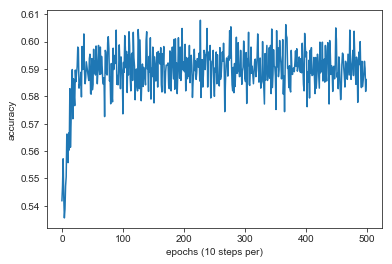

In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500, 
            epochs=500, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dim=3,
            batch_size=500, 
            epochs=50, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500, 
            epochs=70, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

### train dual gold_diff win model

In [ ]:
training_file_dual_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'dual_gold_win_novocab_dota2_training_data.tfrecords')
validation_file_dual_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'dual_gold_win_novocab_dota2_validation_data.tfrecords')

Train for 50 steps, validate for 50 steps
Epoch 1/20
50/50 - 6s - loss: 0.7901 - gold_diff_loss: 1.0018 - radiant_win_loss: 0.6899 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5434 - val_loss: 0.7896 - val_gold_diff_loss: 1.0064 - val_radiant_win_loss: 0.6890 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5430
Epoch 2/20
50/50 - 4s - loss: 0.7865 - gold_diff_loss: 0.9979 - radiant_win_loss: 0.6867 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5508 - val_loss: 0.7870 - val_gold_diff_loss: 1.0016 - val_radiant_win_loss: 0.6869 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5450
Epoch 3/20
50/50 - 4s - loss: 0.7849 - gold_diff_loss: 1.0023 - radiant_win_loss: 0.6846 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5491 - val_loss: 0.7858 - val_gold_diff_loss: 1.0237 - val_radiant_win_loss: 0.6834 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5478
Epoch 4/20
50/50 - 4s - loss: 0.7857 - gold_di

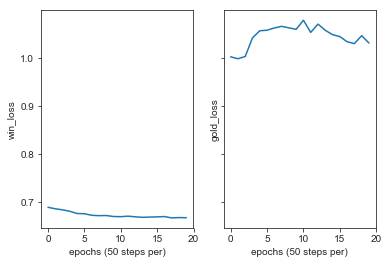

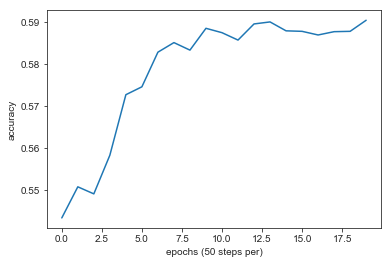

In [88]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_dual(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=20, 
            aux_weight=0.1,
            training_path=training_file_dual_novocab, 
            validation_path=validation_file_dual_novocab,
            compression_type='GZIP')

Train for 50 steps, validate for 50 steps
Epoch 1/40
50/50 - 8s - loss: 0.7897 - gold_diff_loss: 0.9931 - radiant_win_loss: 0.6904 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5414 - val_loss: 0.7865 - val_gold_diff_loss: 0.9884 - val_radiant_win_loss: 0.6876 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5467
Epoch 2/40
50/50 - 5s - loss: 0.7834 - gold_diff_loss: 0.9847 - radiant_win_loss: 0.6849 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5509 - val_loss: 0.7807 - val_gold_diff_loss: 0.9725 - val_radiant_win_loss: 0.6835 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5453
Epoch 3/40
50/50 - 4s - loss: 0.7764 - gold_diff_loss: 0.9729 - radiant_win_loss: 0.6791 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5629 - val_loss: 0.7715 - val_gold_diff_loss: 0.9568 - val_radiant_win_loss: 0.6758 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5737
Epoch 4/40
50/50 - 4s - loss: 0.7682 - gold_di

Epoch 28/40
50/50 - 4s - loss: 0.7633 - gold_diff_loss: 0.9434 - radiant_win_loss: 0.6689 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5859 - val_loss: 0.7636 - val_gold_diff_loss: 0.9509 - val_radiant_win_loss: 0.6685 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5908
Epoch 29/40
50/50 - 4s - loss: 0.7643 - gold_diff_loss: 0.9606 - radiant_win_loss: 0.6683 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5918 - val_loss: 0.7639 - val_gold_diff_loss: 0.9475 - val_radiant_win_loss: 0.6691 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5894
Epoch 30/40
50/50 - 4s - loss: 0.7626 - gold_diff_loss: 0.9437 - radiant_win_loss: 0.6682 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5888 - val_loss: 0.7651 - val_gold_diff_loss: 0.9515 - val_radiant_win_loss: 0.6700 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5879
Epoch 31/40
50/50 - 4s - loss: 0.7621 - gold_diff_loss: 0.9541 - radiant_win_loss: 0.

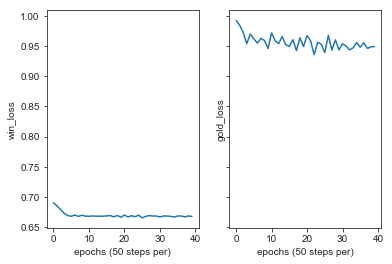

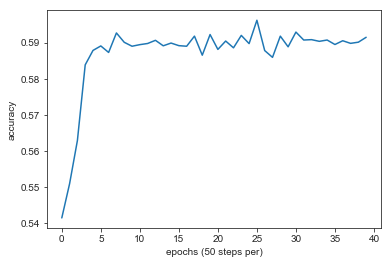

In [91]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_dual(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=40, 
            aux_weight=0.1,
            training_path=training_file_dual_novocab, 
            validation_path=validation_file_dual_novocab,
            compression_type='GZIP')

### train triple gold_diff, total_gold, radiant_win model

In [15]:
training_file_triple_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'triple_gold_win_novocab_dota2_training_data.tfrecords')
validation_file_triple_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'triple_gold_win_novocab_dota2_validation_data.tfrecords')

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191101-195407/saved_model/assets


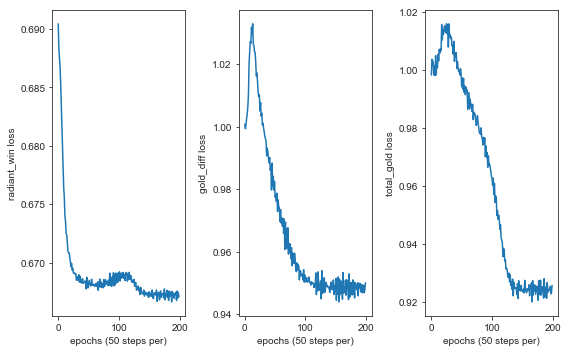

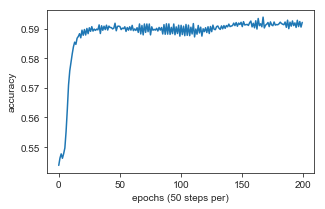

In [190]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_triple(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=2000,
            epochs=200, 
            aux_weight=0.2,
            training_path=training_file_triple_novocab, 
            validation_path=validation_file_triple_novocab,
            compression_type='GZIP')

### train penta linear model (2xgold 2xtower and win)

In [29]:
training_file_penta_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'penta_gold_win_towdam_novocab_dota2_training_data.tfrecords')
validation_file_penta_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'penta_gold_win_towdam_novocab_dota2_validation_data.tfrecords')

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191103-091614/saved_model/assets


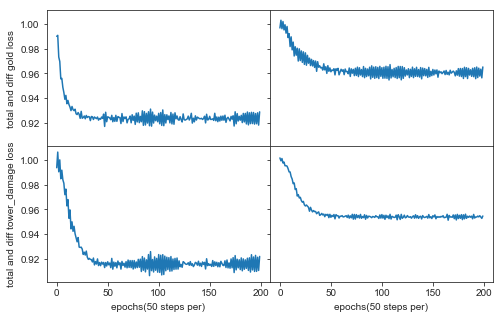

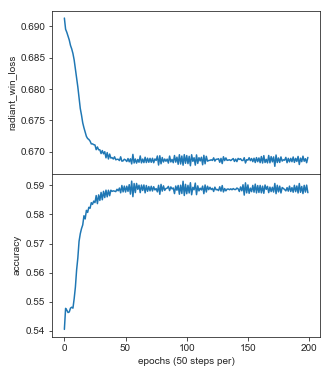

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=2000,
            epochs=200, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: log_dir/20191103-082121/saved_model/assets


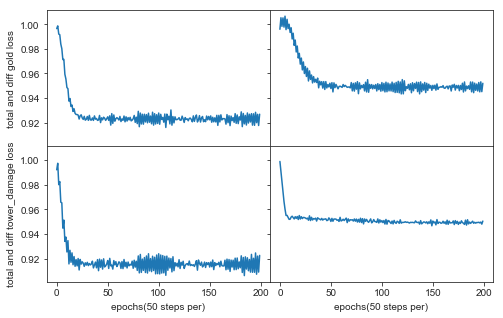

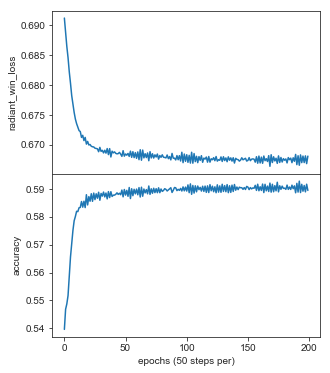

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=200, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=False)

INFO:tensorflow:Assets written to: log_dir/20191103-101110/saved_model/assets


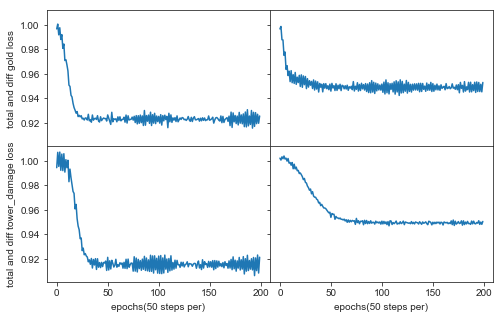

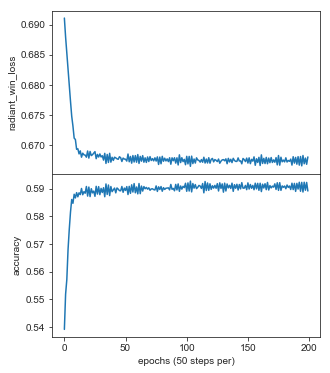

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=200, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191103-201219/saved_model/assets


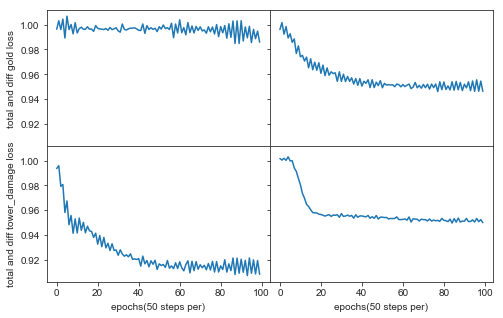

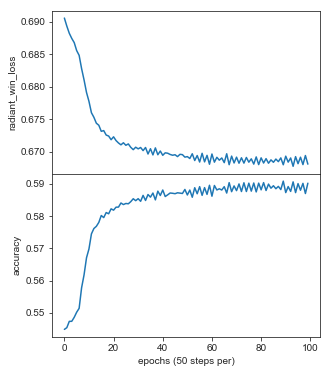

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=2000,
            epochs=100, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191103-225242/saved_model/assets


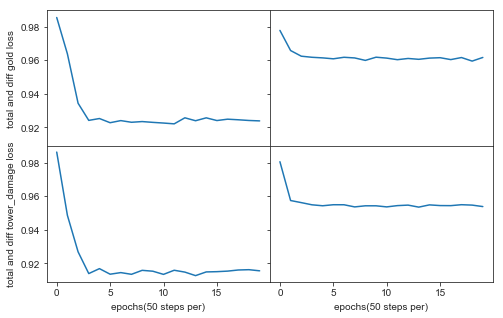

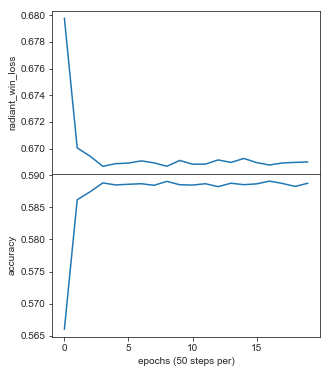

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=10000,
            epochs=20, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191103-231640/saved_model/assets


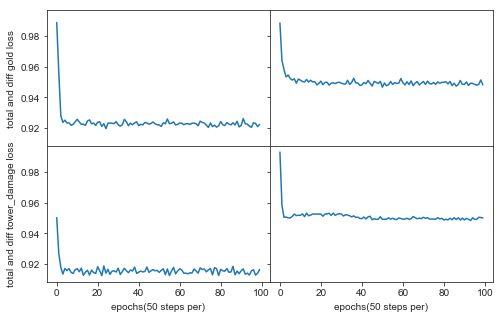

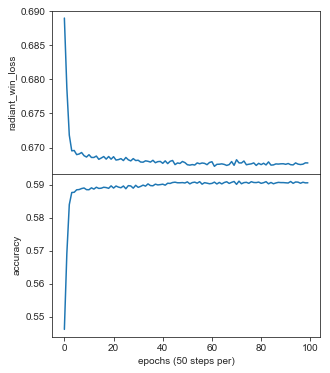

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=10000,
            epochs=100, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191103-214741/saved_model/assets


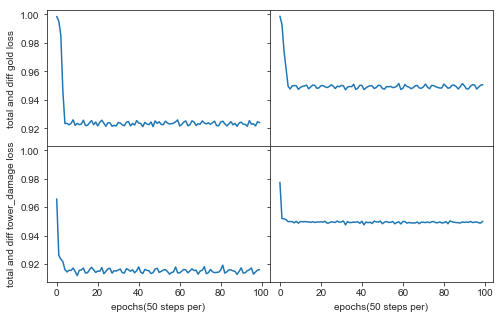

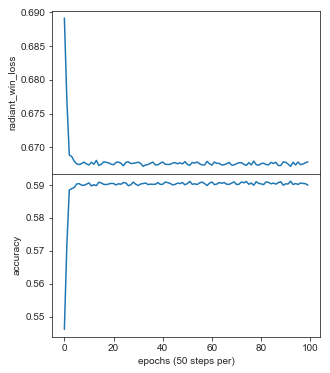

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=5000,
            epochs=100, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

### train radiant_win model with feature columns
not needed and possibly a worse architecture (hard to inspect it though)

In [97]:
training_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_windota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_windota2_validation_data.tfrecords')
categorical_columns = [tf.feature_column.categorical_column_with_vocabulary_list(
                                                'radiant_heroes',
                                                hero_vocab),
                               tf.feature_column.categorical_column_with_vocabulary_list(
                                                'dire_heroes',
                                                hero_vocab)]
indicator_columns = [tf.feature_column.indicator_column(
                                        categorical_columns[0]),
                            tf.feature_column.indicator_column(
                                        categorical_columns[1])]
embedding_dim = 3
embedding_columns = [tf.feature_column.embedding_column(
                                categorical_columns[0],
                                embedding_dim),
                    tf.feature_column.embedding_column(
                                categorical_columns[1],
                                embedding_dim)]

In [98]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_model(optimizer,
            indicator_columns,
            batch_size=500, 
            epochs=5, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

NameError: name 'vocab_len' is not defined

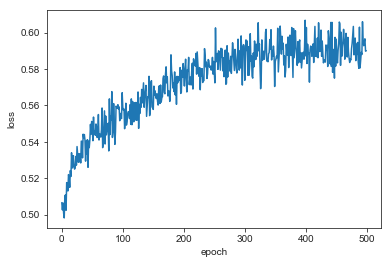

In [82]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_model(optimizer,
            embedding_columns,
            batch_size=500, 
            epochs=500, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

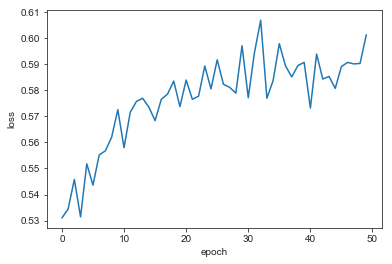

In [85]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_model(optimizer,
            embedding_columns,
            batch_size=500, 
            epochs=50, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

In [51]:
%load_ext tensorboard

In [52]:
log = os.path.join('..','..','..','tmp_log_dir')
%tensorboard --logdir '../../../tmp_log_dir' --reload_multifile=true

Reusing TensorBoard on port 6014 (pid 9324), started 21:09:55 ago. (Use '!kill 9324' to kill it.)